# *Maternal Mortality Risk Analysis: Exploring Factors Impacting Maternal Well-being*

## Introduction

### **\<\<INSERT INTRODUCTION HERE\>\>**

## Preliminary exporatory Data Analysis

In [19]:
# Import necessary libraries

library(rvest)
library(tidyverse)
library(tidymodels)
library(repr)

### Reading the dataset from the web into R

#### General preface

The dataset we have chosen is hosted on a website which does not have a supported R API.

After searching extensively for a terms of service to see if scraping is disallowed, it was not found.

Thus, we will be using web scraping in order to retrieve our dataset.

#### Website analysis

- After studying the source code of the website, it is clear that the dataset is retrieved by pressing a button, which sends a GET request fetching the file which is hosted on the website. (the "button" is not of type `<button>`, rather it is `<a>` -  a link.)

- Note that the original file the website hands to us is a .zip file, which we will need to extract

- If we can find the url to the file, we can send a GET request which should retrieve the dataset file data which we can then store locally in a file. (We will more likely than not use a built in R function or library to do this)

- The download button is unique in one way, it is the only element in the HTML file which has the unique combination of classes that it has, making it easy to extract it from the webpage.

#### General Scraping procedure

**Part 1**
- Retrieve source code of website
- Use CSS selectors to get the `<a></a>` elment that contains the link to the file
- Extract the url which is held in the `href` attribute of the `<a></a>` tag

**Part 2**
- Download the dataset file pointed to by the url
- Extract the .zip file containing the dataset csv
- Read the csv file into R

In [20]:
# Part 1

dataset_website_root <- "https://archive.ics.uci.edu"
dataset_webpage_url <- "/dataset/863/maternal+health+risk"

page = paste(dataset_website_root, dataset_webpage_url, sep = "") |>
    read_html()   # Contains html source code of website

selectors <- paste(".btn-primary.btn.w-full.text-primary-content", sep = ",")    # CSS selectors created inspecting the download button 

population_nodes <- html_nodes(page, selectors)  # Contains all the elements that match the CSS selector criteria (only the button we want)

file_url <- population_nodes |> html_attr("href")    # Gets the href of the download button (filepath of dataset file relative to the website root)

download_url <- paste(dataset_website_root, file_url, sep = "") # Url of webpage + path to file

In [21]:
# Part 2

temp <- tempfile() # Create a temporary file to store the zip

download.file(download_url,temp) # Download the zip file from the website and store it in the temporary file

original_name <- unzip(temp) # Extract and save the csv file from the zip
unlink(temp) # Remove the temporary zip file

new_filename <- "maternal_health.csv" # improved filename removing whitespaces

file.rename(original_name, new_filename) # Rename the file to be easier to access and removing whitespace in the original name

maternal_health <- read_csv(new_filename, skip = 1,
                  col_names = c("age", "systolic_blood_pressure", "diastolic_blood_pressure", "blood_glucose", "body_temperature", "heart_rate", "risk_level"))

[1] TRUE

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): risk_level
dbl (6): age, systolic_blood_pressure, diastolic_blood_pressure, blood_gluco...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


If the data has already been downloaded to our local machine, it can simply be read using the `read_*` function depending on the type of file (csv in our case hence `read_csv()`)

In [22]:
maternal_health <- read_csv("maternal_health.csv", skip = 1,
                  col_names = c("age", "systolic_blood_pressure", "diastolic_blood_pressure", "blood_glucose", "body_temperature", "heart_rate", "risk_level"))

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): risk_level
dbl (6): age, systolic_blood_pressure, diastolic_blood_pressure, blood_gluco...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Cleaning and Wrangling the data

#### Tidying data

Our dataset is already tidy, we say this because

- each row is a single observation,

- each column is a single variable, and

- each value is a single cell (i.e., its entry in the data frame is not shared with another value).

Our dataset is already in a clean format, but to get it ready for training we have to set the factors 

#### Splitting the data into training and test data

We will split the data into two parts. 75% will be used as training data and 25% will be used as test data.

In [23]:
maternal_health <- maternal_health |> mutate(risk_level = as_factor(risk_level))

# ----- Splitting the data ------

maternal_health_split <- maternal_health |> 
    initial_split(prop = 0.75, strata = risk_level) # Split the data 3:1


maternal_health_train <- training(maternal_health_split) # Assign the training data to maternal_health_train
maternal_health_test <-testing(maternal_health_split) # Assign the testing data to maternal_health_test

glimpse(maternal_health_train)

Rows: 760
Columns: 7
$ age                      <dbl> 25, 29, 30, 23, 25, 40, 23, 25, 32, 63, 25, 5…
$ systolic_blood_pressure  <dbl> 130, 90, 140, 140, 140, 140, 140, 140, 140, 1…
$ diastolic_blood_pressure <dbl> 80, 70, 85, 80, 100, 100, 90, 100, 100, 90, 1…
$ blood_glucose            <dbl> 15.00, 8.00, 7.00, 7.01, 7.01, 18.00, 6.80, 6…
$ body_temperature         <dbl> 98, 100, 98, 98, 98, 98, 98, 98, 98, 98, 98, …
$ heart_rate               <dbl> 86, 80, 70, 70, 80, 90, 70, 80, 78, 90, 80, 9…
$ risk_level               <fct> high risk, high risk, high risk, high risk, h…


### Summarizing the data using training data

We first show a summary of the number and percentage of the three categories, high risk, low risk and medium risk.

Secondly, we show a table of the mean values for all our variables

In [24]:
total_number <- nrow(maternal_health_train)

maternal_health_count_categories <- maternal_health_train |>
    group_by(risk_level) |>
    summarize(count = n(), percentage = round((n() / total_number) * 100))

maternal_health_variable_means = maternal_health_train |>
    summarize(across(age:heart_rate, \(x) mean(x, na.rm = TRUE)))

#### Summary of the distribution of high risk, low risk and medium risk for maternal mortality 

In [25]:
maternal_health_count_categories

risk_level,count,percentage
<fct>,<int>,<dbl>
high risk,204,27
low risk,304,40
mid risk,252,33


#### Summary of the mean of the different variables affecting maternal mortality

In [26]:
maternal_health_variable_means 

age,systolic_blood_pressure,diastolic_blood_pressure,blood_glucose,body_temperature,heart_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29.58816,113.5276,76.78816,8.721224,98.65711,74.16316


### Visualisation using training data

We have made graphs to illustrate the variables and how they have an affect on the category.

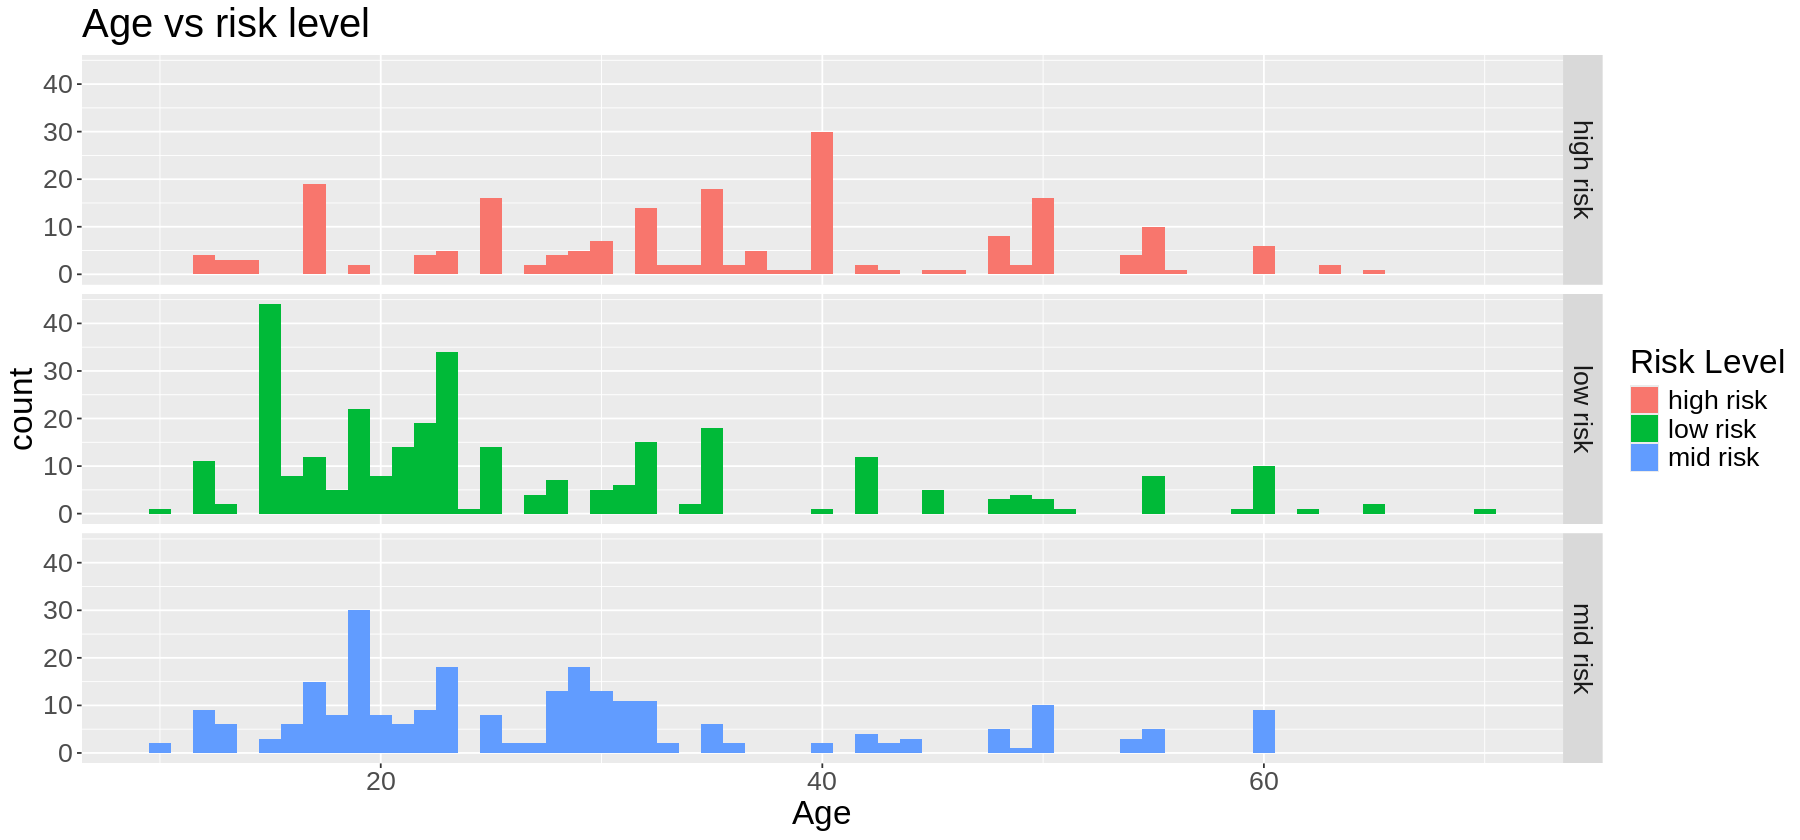

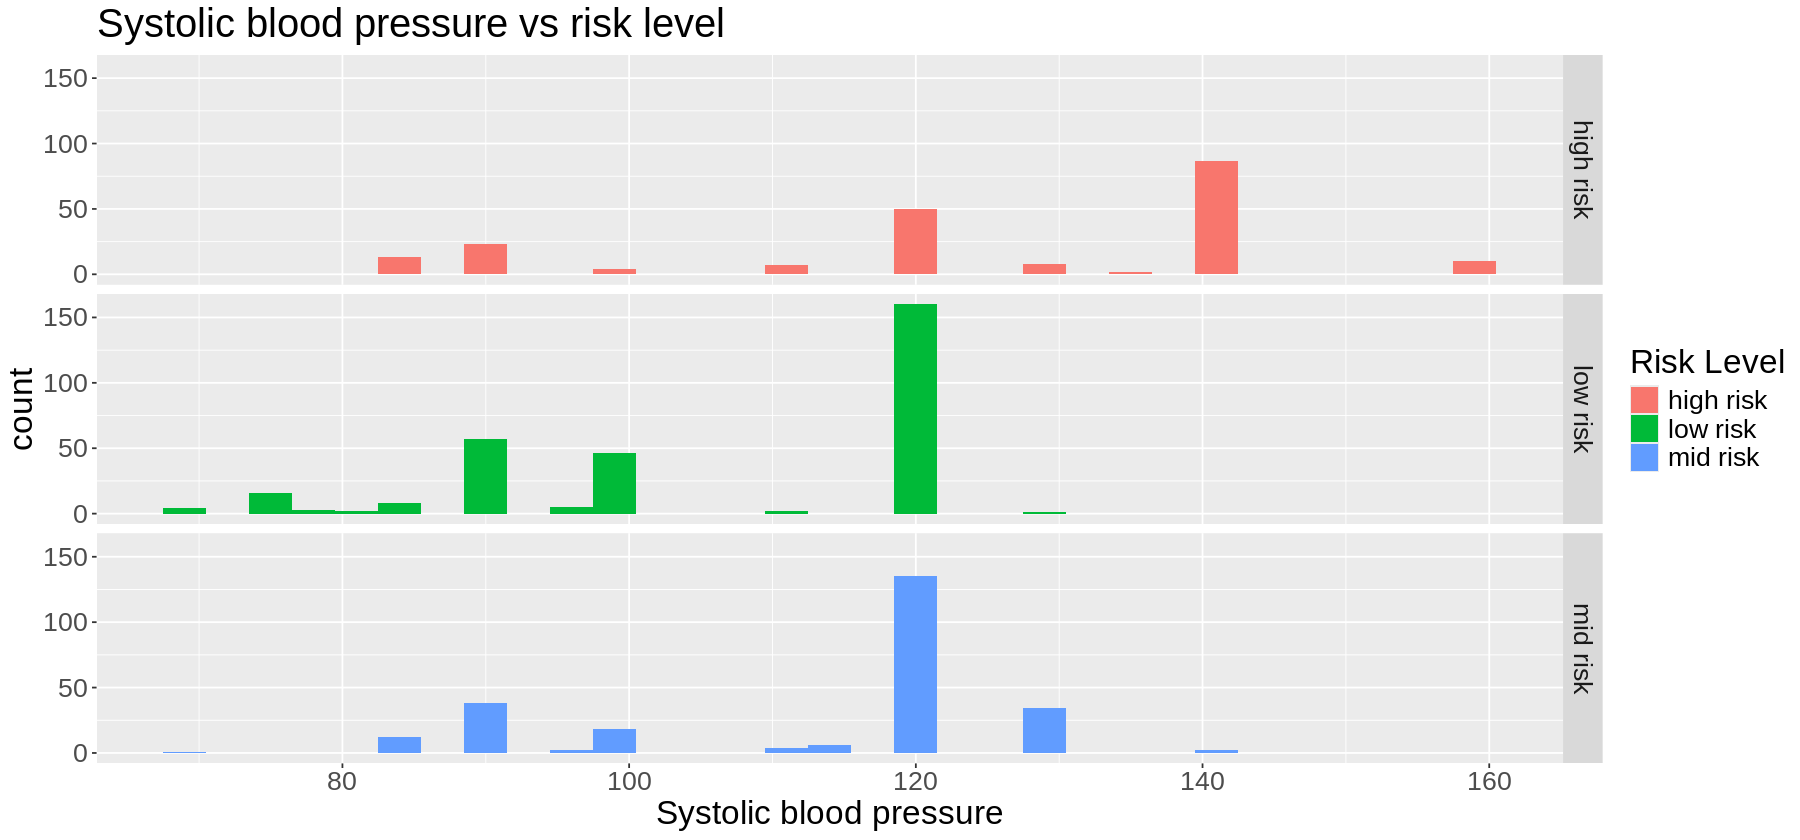

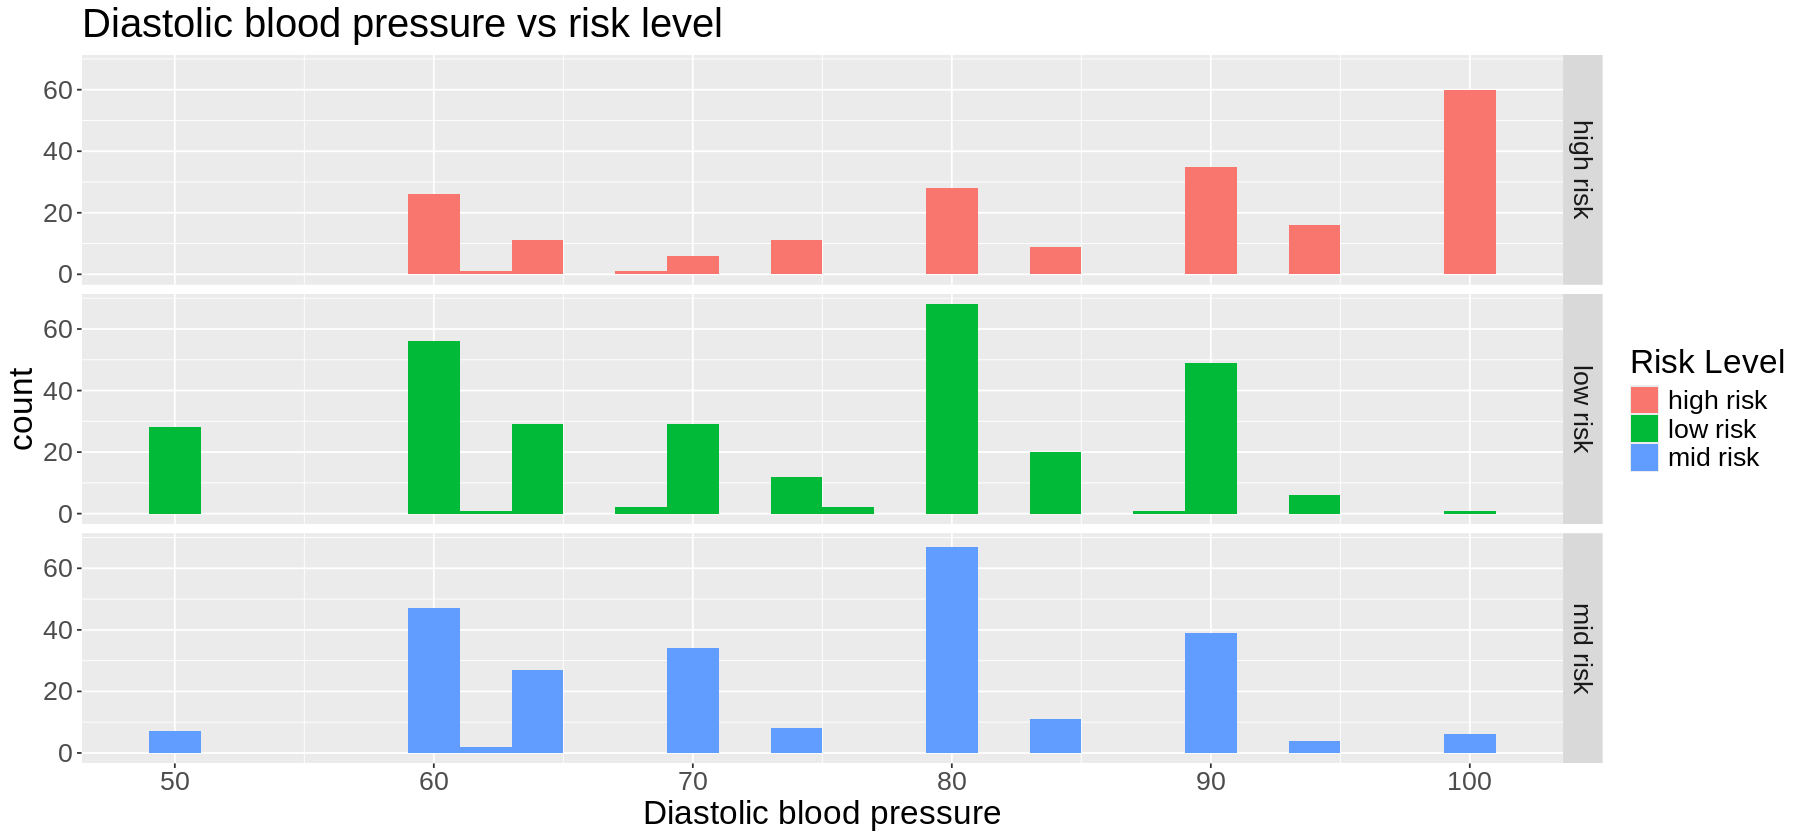

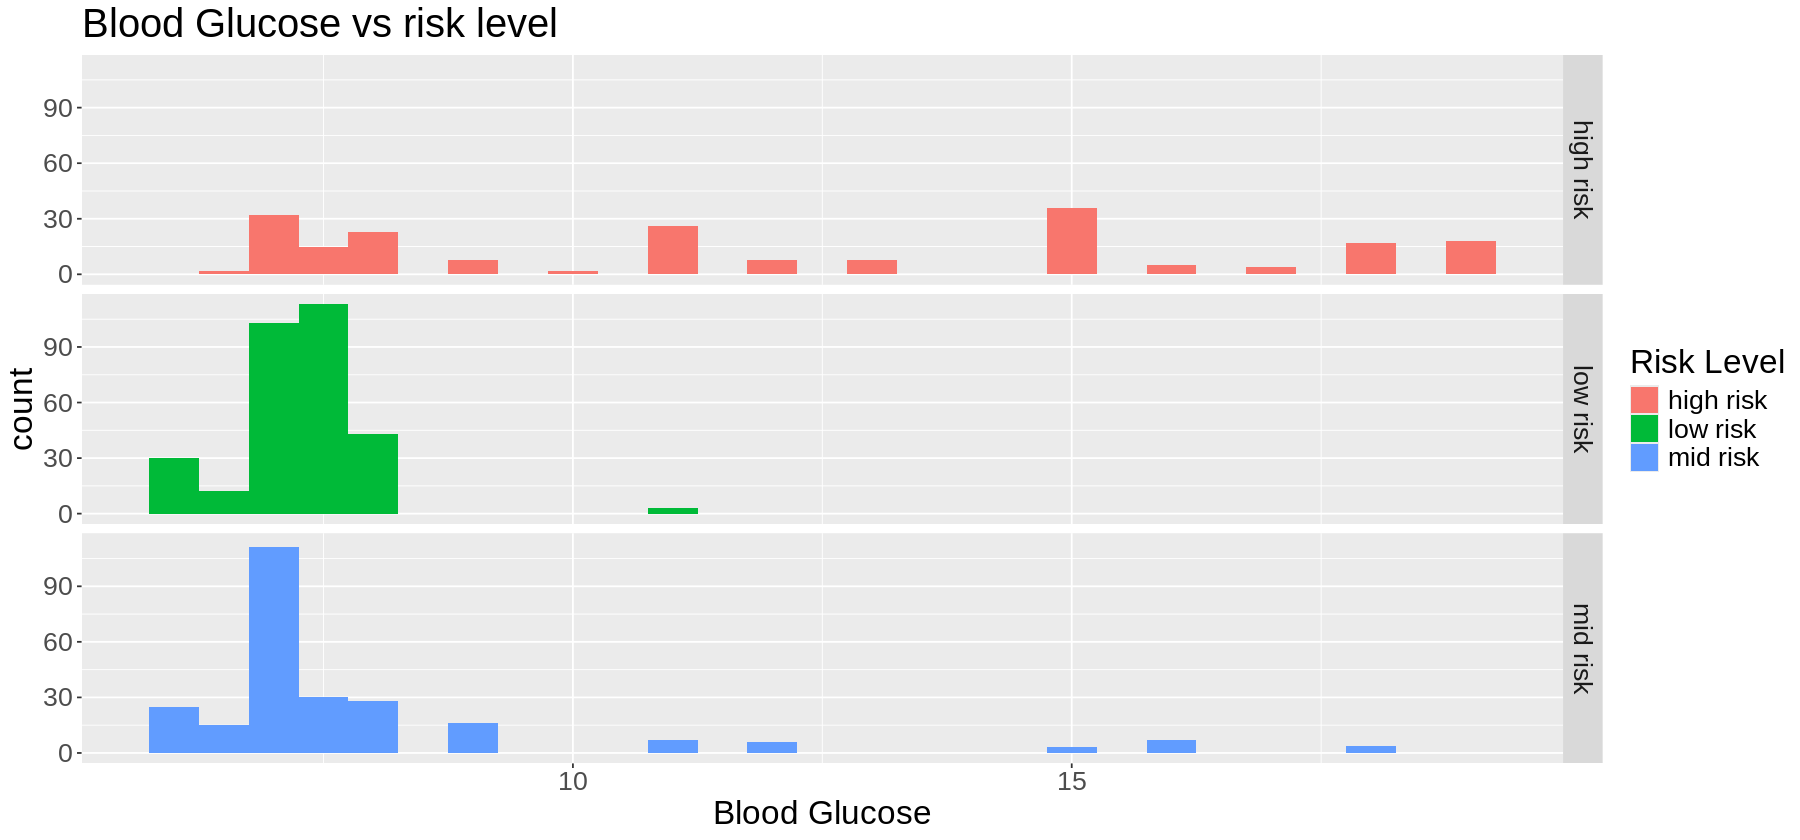

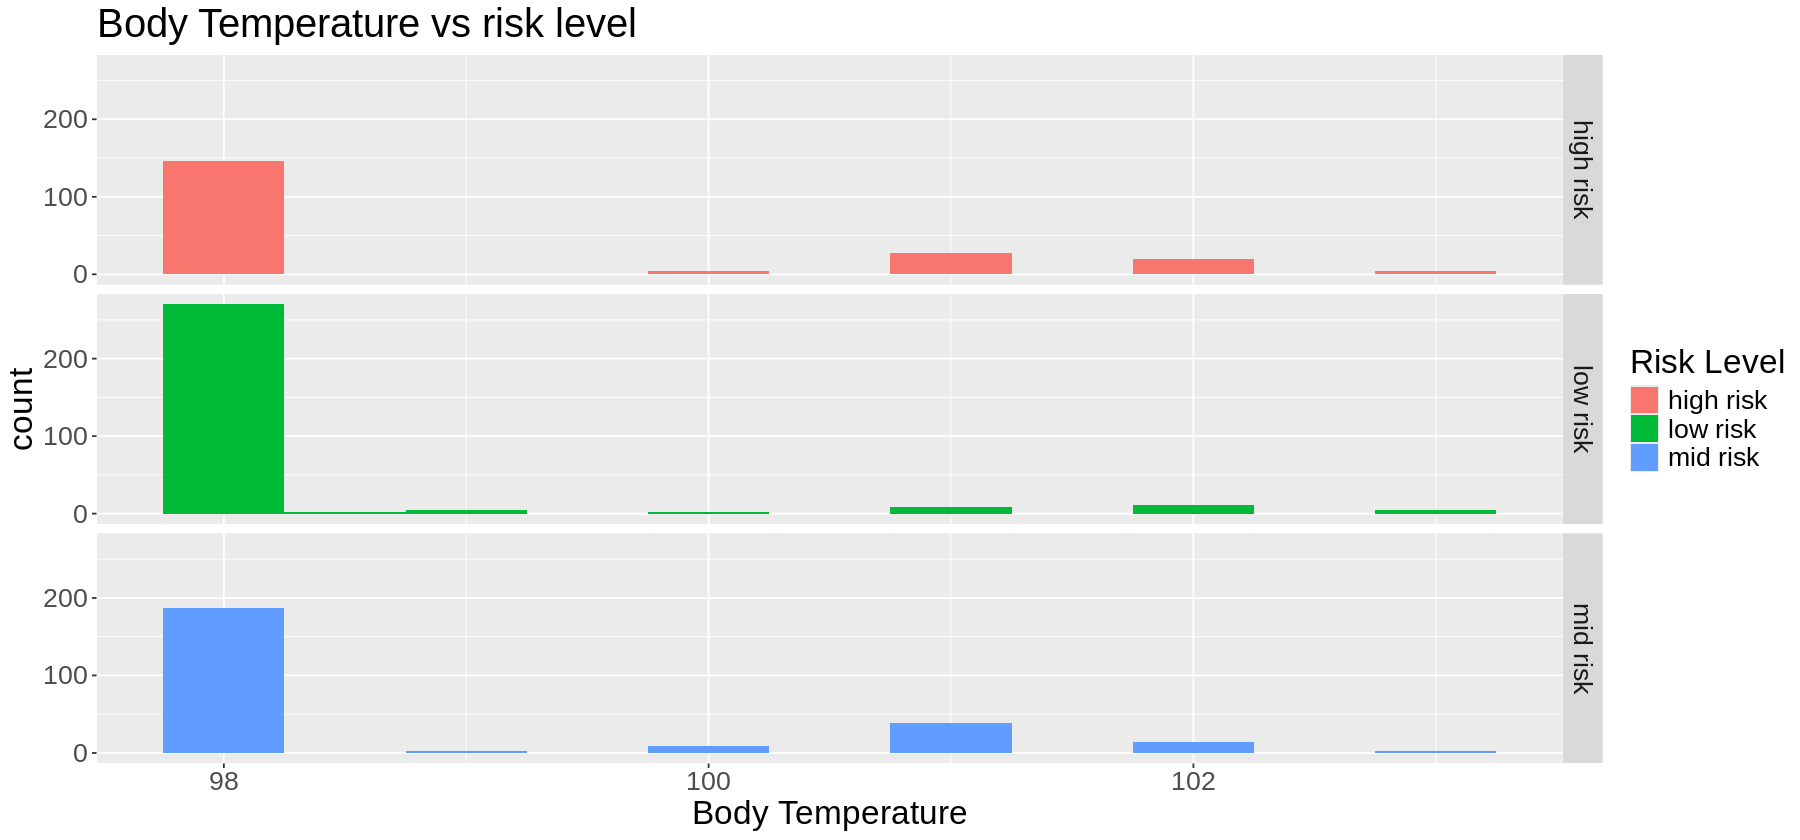

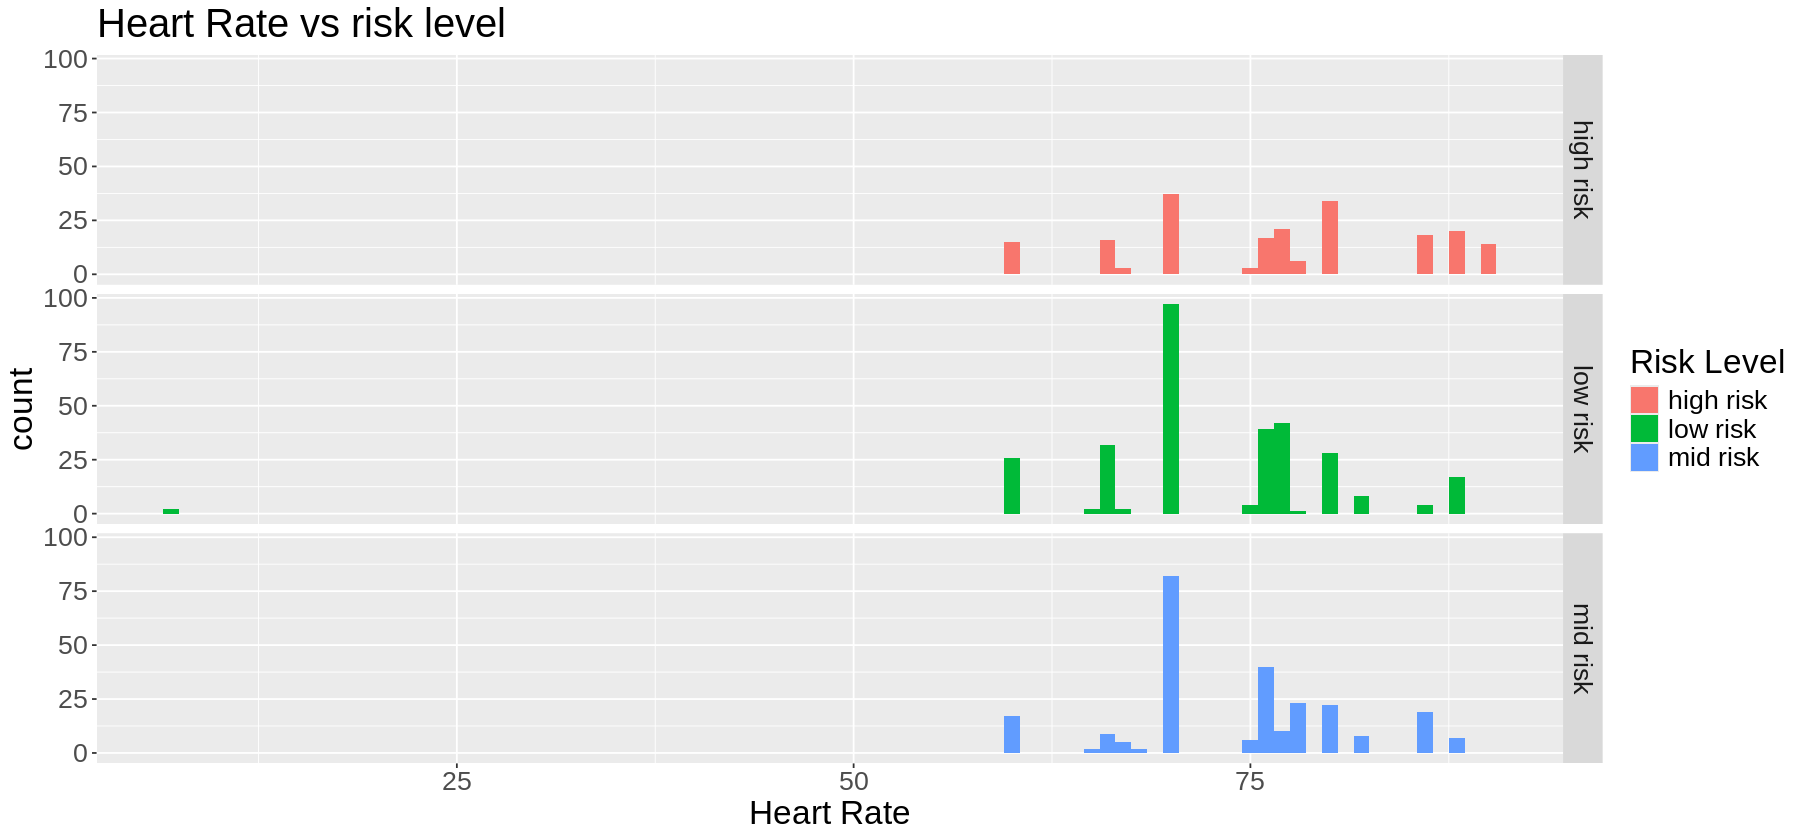

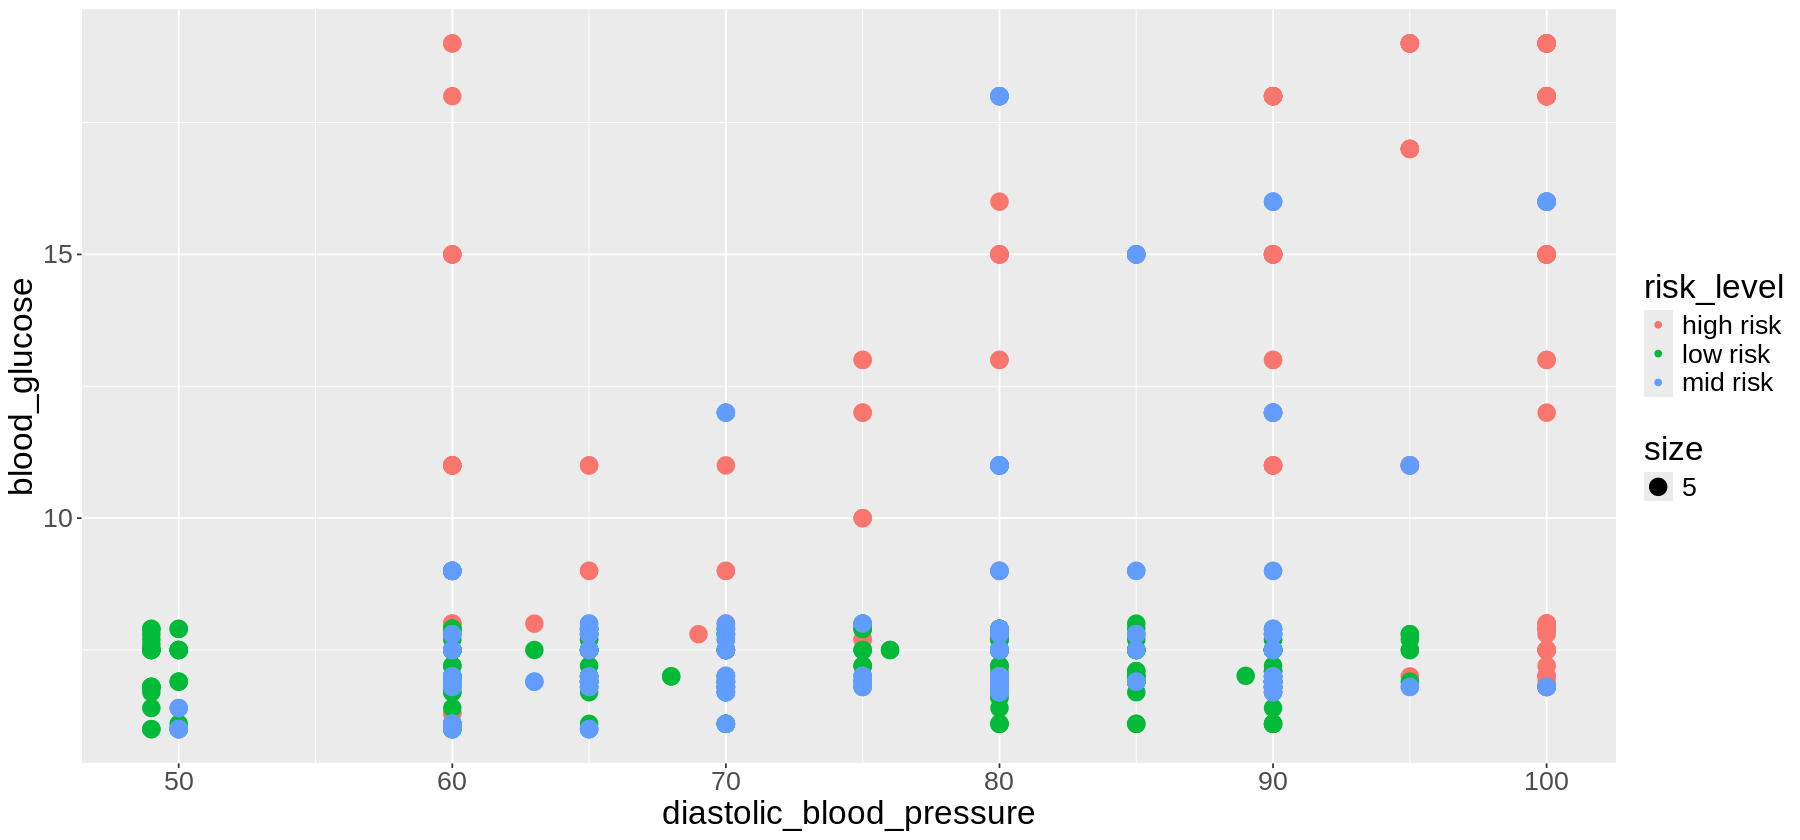

In [27]:
options(repr.plot.width = 15, repr.plot.height = 7) 

maternal_health_train |>
    ggplot(aes(x = age, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 1) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Age", title = "Age vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = systolic_blood_pressure, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 3) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Systolic blood pressure", title = "Systolic blood pressure vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = diastolic_blood_pressure, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 2) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Diastolic blood pressure", title = "Diastolic blood pressure vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = blood_glucose, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 0.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Blood Glucose", title = "Blood Glucose vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = body_temperature, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 0.5) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Body Temperature", title = "Body Temperature vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))
maternal_health_train |>
    ggplot(aes(x = heart_rate, fill = as_factor(risk_level))) + geom_histogram(alpha = 1, position = "identity", binwidth = 1) + facet_grid(rows = vars(risk_level)) +
    labs(x = "Heart Rate", title = "Heart Rate vs risk level", fill = "Risk Level") + theme(text = element_text(size = 20))

maternal_health_train |> ggplot(aes(x = diastolic_blood_pressure, y = blood_glucose, color = risk_level, size = 5)) + geom_point() + theme(text = element_text(size = 20))

# Method

## **\<\<INSERT METHOD HERE\>\>**